In [6]:
import os
import sys

import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LeakyReLU, ReLU, Conv2DTranspose, Conv2D, Reshape, Dropout, Flatten
import random

# Set random seeds for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

from aerosandbox import Airfoil, KulfanAirfoil

import pandas as pd

import plotly.graph_objects as go

2025-03-26 16:12:18.744868: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


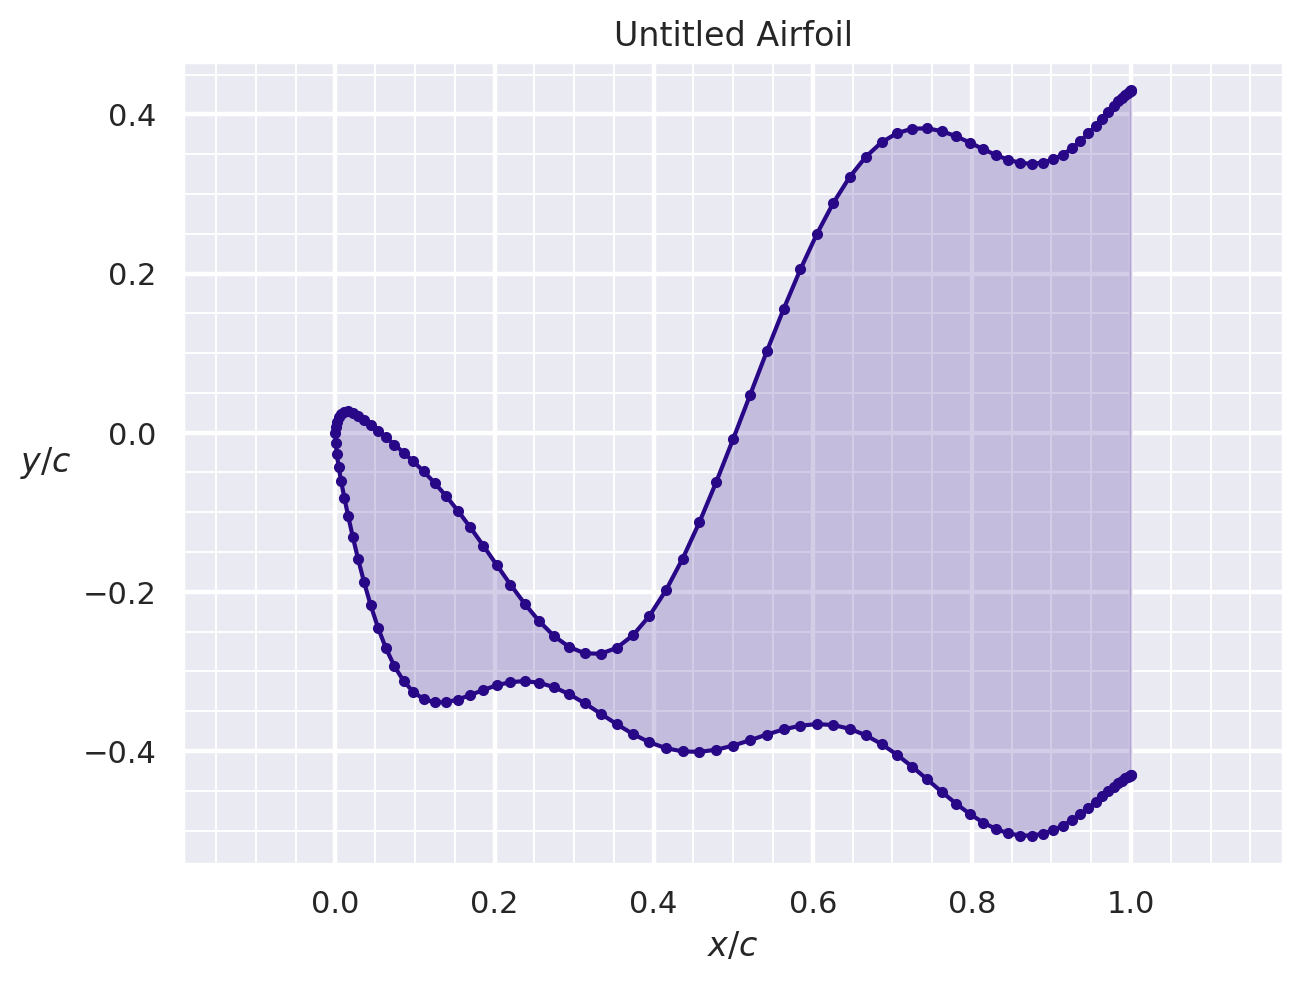

In [4]:

import tensorflow as tf
from tensorflow.keras.layers import Layer
import numpy as np


class CSTLayer(Layer):
    def __init__(self, **kwargs):
        super(CSTLayer, self).__init__(**kwargs)
        self.N1 = 0.5
        self.N2 = 1
        self.n_points_per_side = 75

    def call(self, inputs, parameters):
        """
        Args:
            inputs: A 3D tensor of shape (batch_size, 2, num_weights).
                   Represents the CST weights for the upper and lower surfaces.
            parameters: A 2D tensor of shape (batch_size, 2).
                       Represents batch-specific parameters:
                       - parameters[:, 0]: TE_thickness for each sample in the batch.
                       - parameters[:, 1]: leading_edge_weight for each sample in the batch.
        """

        # Inputs is a 3D tensor: (batch_size, 2, num_weights)
        # For example, shape: (batch_size, 2, 12)
        batch_size = tf.shape(inputs)[0]
        num_weights = tf.shape(inputs)[2]

        # Split into lower and upper weights
        lower_weights = inputs[:, 0, :]  # Shape: (batch_size, num_weights)
        upper_weights = inputs[:, 1, :]  # Shape: (batch_size, num_weights)

        # Extract batch-specific parameters
        leading_edge_weight = parameters[:, 0]  # Shape: (batch_size,)
        TE_thickness = parameters[:, 1]  # Shape: (batch_size,)

        # Generate cosinically spaced points
        x = (
            1 - tf.cos(tf.linspace(0.0, np.pi, self.n_points_per_side))
        ) / 2  # Shape: (n_points_per_side,)

        # Class function
        C = (x**self.N1) * ((1 - x) ** self.N2)  # Shape: (n_points_per_side,)

        def shape_function(w):
            # Shape function (Bernstein polynomials)
            N = tf.cast(tf.shape(w)[1] - 1, dtype=tf.float32)  # num_weights - 1

            # Compute binomial coefficients using TensorFlow
            k = tf.range(N + 1, dtype=tf.float32)  # Shape: (num_weights,)
            log_comb = tf.math.lgamma(N + 1) - tf.math.lgamma(k + 1) - tf.math.lgamma(N - k + 1)
            K = tf.exp(log_comb)  # Shape: (num_weights,)

            # Expand dimensions for broadcasting
            K = tf.expand_dims(K, axis=-1)  # Shape: (num_weights, 1)
            x_expanded = tf.expand_dims(x, axis=0)  # Shape: (1, n_points_per_side)
            arange = tf.expand_dims(k, axis=-1)  # Shape: (num_weights, 1)

            # Compute Bernstein polynomials
            S_matrix = (
                K * (x_expanded**arange) * ((1 - x_expanded) ** (N - arange))
            )  # Shape: (num_weights, n_points_per_side)

            # Multiply by weights and sum over the Bernstein polynomials
            w_expanded = tf.expand_dims(w, axis=-1)  # Shape: (batch_size, num_weights, 1)
            S_x = tf.reduce_sum(w_expanded * S_matrix, axis=1)  # Shape: (batch_size, n_points_per_side)

            # Calculate the output y
            y = C * S_x  # Shape: (batch_size, n_points_per_side)
            return y

        # Apply shape function to lower and upper weights
        y_lower = shape_function(lower_weights)  # Shape: (batch_size, n_points_per_side)
        y_upper = shape_function(upper_weights)  # Shape: (batch_size, n_points_per_side)

        # Trailing edge thickness (TE thickness)
        # Reshape TE_thickness for broadcasting: (batch_size, 1)
        TE_thickness = tf.expand_dims(TE_thickness, axis=-1)  # Shape: (batch_size, 1)
        y_lower -= x * TE_thickness / 2  # Shape: (batch_size, n_points_per_side)
        y_upper += x * TE_thickness / 2  # Shape: (batch_size, n_points_per_side)

        # Leading edge modification (LEM)
        # Reshape leading_edge_weight for broadcasting: (batch_size, 1)
        leading_edge_weight = tf.expand_dims(leading_edge_weight, axis=-1)  # Shape: (batch_size, 1)
        y_lower += (
            leading_edge_weight
            * x
            * (1 - x) ** (tf.cast(num_weights, dtype=tf.float32) + 0.5)
        )
        y_upper += (
            leading_edge_weight
            * x
            * (1 - x) ** (tf.cast(num_weights, dtype=tf.float32) + 0.5)
        )

        # Create airfoil coordinates
        x = tf.tile(tf.expand_dims(x, axis=0), [batch_size, 1])  # Shape: (batch_size, n_points_per_side)
        x = tf.concat([x[:, ::-1], x[:, 1:]], axis=1)  # Shape: (batch_size, 2 * n_points_per_side - 1)
        y = tf.concat([y_upper[:, ::-1], y_lower[:, 1:]], axis=1)  # Shape: (batch_size, 2 * n_points_per_side - 1)

        # Stack x and y coordinates
        coordinates = tf.stack([x, y], axis=-1)  # Shape: (batch_size, 2 * n_points_per_side - 1, 2)
        return coordinates

# Create an instance of the CSTLayer
cst_layer = CSTLayer()

# Create dummy input data
batch_size = 3
num_weights = 12  # Number of CST weights for each surface (upper and lower)
dummy_input = tf.random.normal([batch_size, 2, num_weights])  # Shape: (batch_size, 2, num_weights)
dummy_parameters = tf.random.normal([batch_size, 2])

# Pass the input through the CSTLayer
coordinates = cst_layer(dummy_input, dummy_parameters)  # Shape: (batch_size, 2 * n_points_per_side - 1, 2)

test = Airfoil(coordinates=coordinates[0])
test.draw()

Output shape:  (3, 2, 12)
Coordinates shape:  (3, 149, 2)
tf.Tensor(
[[0.4691338  1.2928448 ]
 [0.42674905 0.37046   ]
 [0.6258706  0.13872336]], shape=(3, 2), dtype=float32)


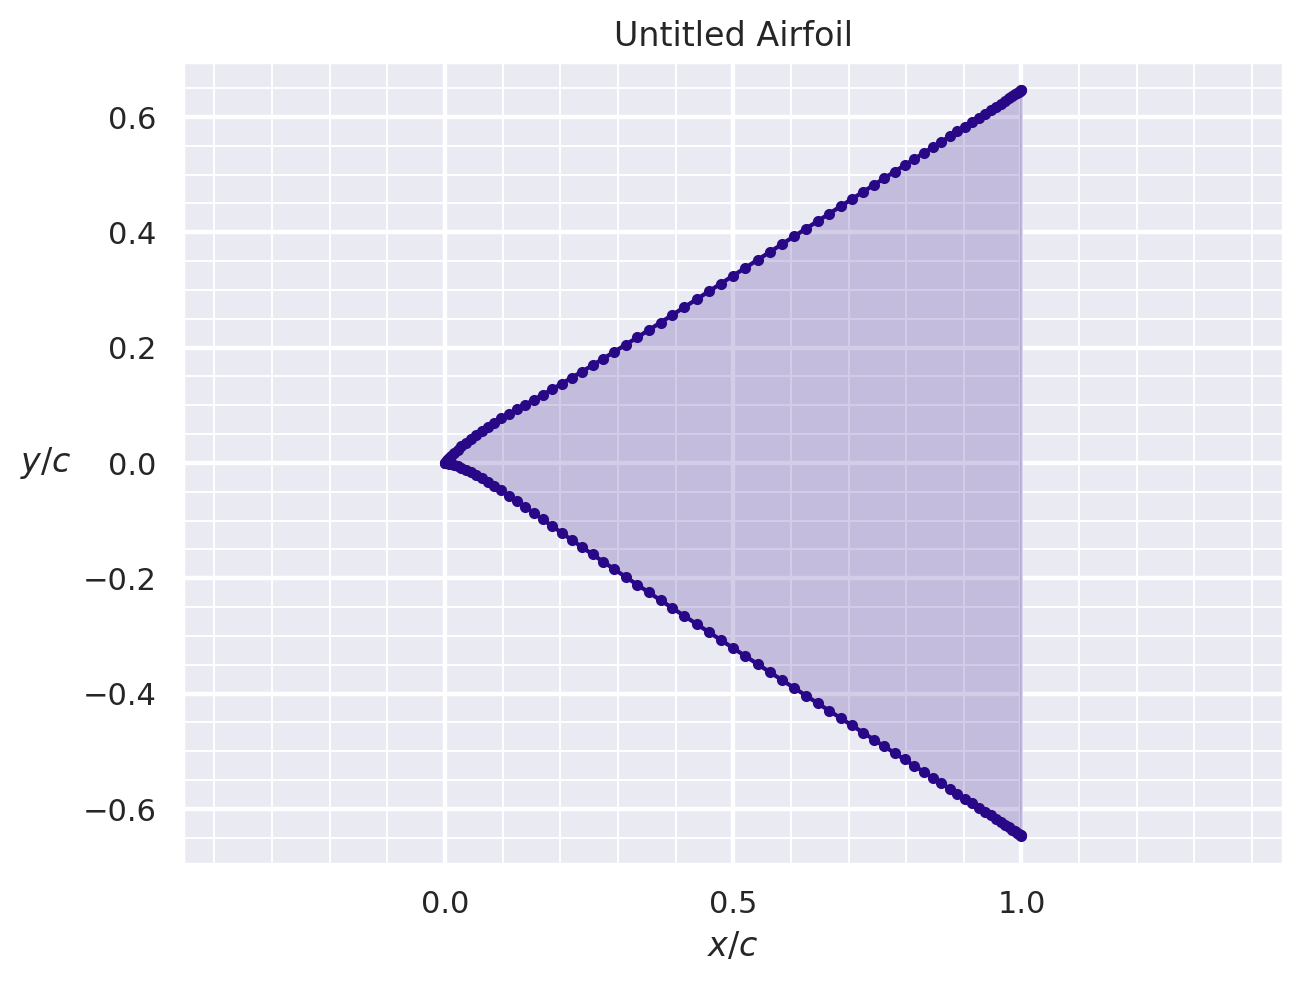

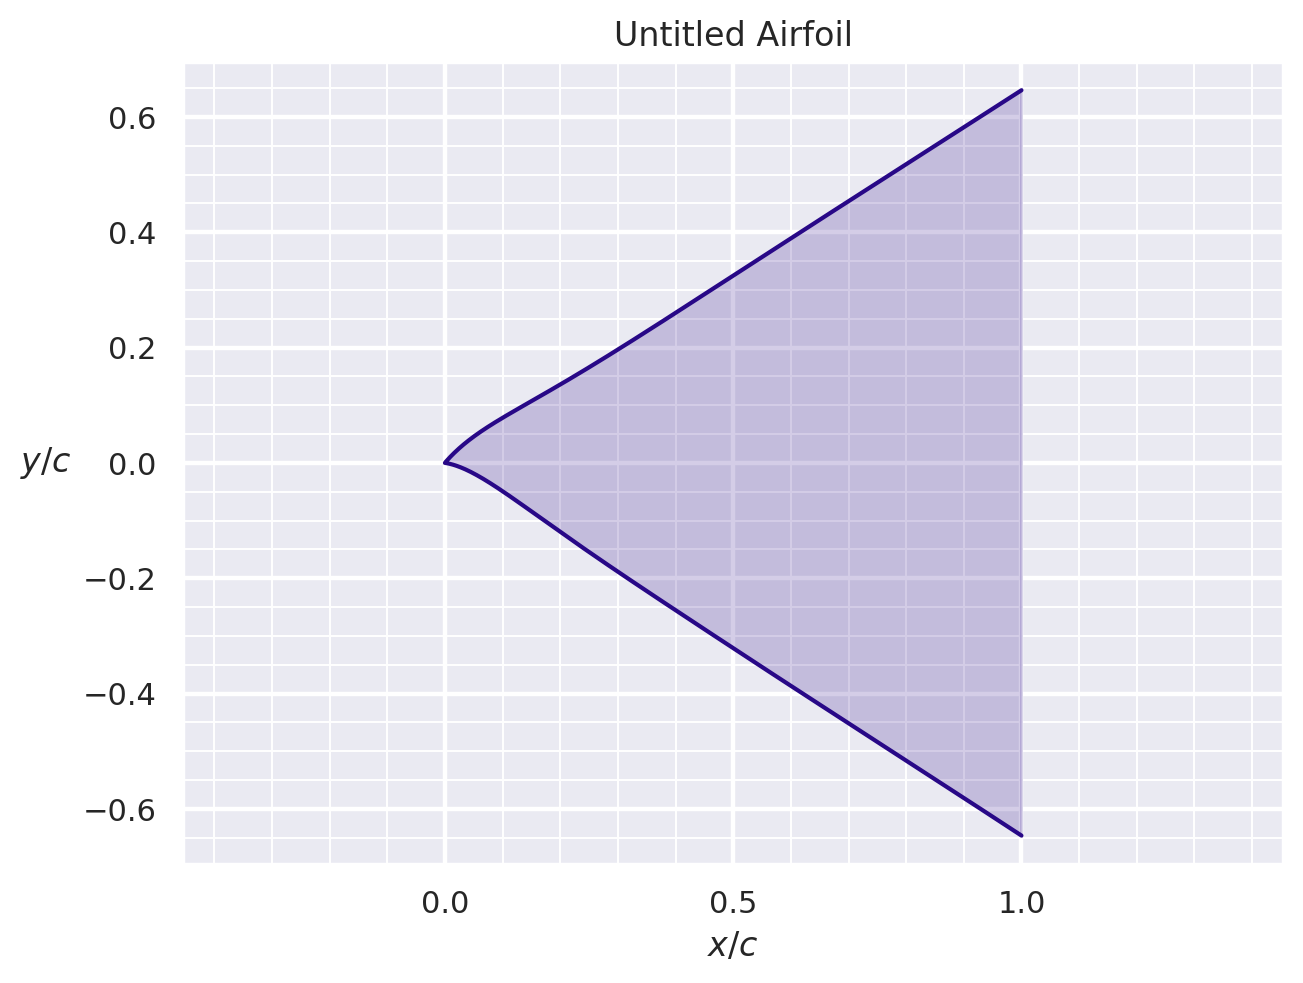

In [12]:
from keras.saving import register_keras_serializable

class CSTGenerator(tf.keras.Model):
    '''
    * Refs:
        - Lin, Jinxing & Zhang, Chenliang & Xie, Xiaoye & Shi, Xingyu & Xu, Xiaoyu & Duan, Yanhui. (2022). CST-GANs: A Generative Adversarial Network Based on CST Parameterization for the Generation of Smooth Airfoils. 600-605. 10.1109/ICUS55513.2022.9987080.
    '''
    def __init__(self, npv: int = 12, latent_dim: int = 128, kernel_size: tuple = (2,4), depth: int = 256, use_modifications = True, **kwargs):
        super().__init__()

        # --- Parameters ---

        '''
        * npv: Number of parameterized variables
        * latent_dim: Dimension of input vector (latent vector)
        * depth: Number of channels after first dense layer
        '''

        self.npv = npv
        self.latent_dim = latent_dim
        self.kernel_size = kernel_size
        self.depth = depth
        self.use_modifications = use_modifications

        # --- Layers ---

        # Fully connected layers
        # CST Weights
        self.dense1 = Dense(self.depth * 2 * self.npv)
        self.batch1 = BatchNormalization(momentum=0.9)
        self.leaky_relu1 = LeakyReLU(0.2)

        self.reshape = Reshape((2, self.npv, self.depth))

        # LEM and TET
        self.dense2 = Dense(self.depth, input_shape=(self.latent_dim,))
        self.batch7 = BatchNormalization(momentum=0.9)
        self.leaky_relu7 = LeakyReLU(0.2)

        self.dense3 = Dense(int(self.depth / 4))
        self.batch8 = BatchNormalization(momentum=0.9)
        self.leaky_relu8 = LeakyReLU(0.2)

        self.dense4 = Dense(2)
        self.relu1 = ReLU()

        # Transposed convolutions
        self.deconv1 = Conv2DTranspose(int(self.depth / 2), self.kernel_size, strides=(1,2), padding='same')
        self.batch2 = BatchNormalization(momentum=0.9)
        self.leaky_relu2 = LeakyReLU(0.2)

        self.deconv2 = Conv2DTranspose(int(self.depth / 4), self.kernel_size, strides=(1,2), padding='same')
        self.batch3 = BatchNormalization(momentum=0.9)
        self.leaky_relu3 = LeakyReLU(0.2)

        self.deconv3 = Conv2DTranspose(int(self.depth / 8), self.kernel_size, strides=(1,2), padding='same')
        self.batch4 = BatchNormalization(momentum=0.9)
        self.leaky_relu4 = LeakyReLU(0.2)

        # Convolutional layers
        self.conv1 = Conv2D(int(self.depth / 16), self.kernel_size, strides=(1,2), padding="same")
        self.batch5 = BatchNormalization(momentum=0.9)
        self.leaky_relu5 = LeakyReLU(0.2)

        self.conv2 = Conv2D(int(self.depth / 32), self.kernel_size, strides=(1,2), padding="same")
        self.batch6 = BatchNormalization(momentum=0.9)
        self.leaky_relu6 = LeakyReLU(0.2)

        self.conv3 = Conv2D(1, self.kernel_size, strides=(1,2), padding="same", activation="tanh")

        # Output layers
        self.final_reshape = Reshape((2, self.npv))

        # Class-Shape Transformation
        self.cst_transform = CSTLayer()

    def call(self, inputs):
        x = self.dense1(inputs) # Input shape: (batch_size, latent_dim)
        x = self.batch1(x)
        x = self.leaky_relu1(x)

        x2 = self.dense2(inputs)
        x2 = self.batch7(x2)
        x2 = self.leaky_relu7(x2)

        x2 = self.dense3(x2)
        x2 = self.batch8(x2)
        x2 = self.leaky_relu8(x2)

        x2 = self.dense4(x2)
        parameters = self.relu1(x2)

        x = self.reshape(x)

        x = self.deconv1(x)
        x = self.batch2(x)
        x = self.leaky_relu2(x)

        x = self.deconv2(x)
        x = self.batch3(x)
        x = self.leaky_relu3(x)

        x = self.deconv3(x)
        x = self.batch4(x)
        x = self.leaky_relu4(x)

        x = self.conv1(x)
        x = self.batch5(x)
        x = self.leaky_relu5(x)

        x = self.conv2(x)
        x = self.batch6(x)
        x = self.leaky_relu6(x)

        x = self.conv3(x)
        weights = self.final_reshape(x)

        if not self.use_modifications:
          parameters = np.zeros_like(parameters)

        coordinates = self.cst_transform(weights, parameters)

        return coordinates, weights, parameters

cst_generator = CSTGenerator()
latent_vector = tf.random.normal([3, 128])
coords, weights, parameters = cst_generator(latent_vector)
print("Output shape: ", weights.shape)
print("Coordinates shape: ", coords.shape)
print(parameters)
# test = KulfanAirfoil(lower_weights=weights[0][0], upper_weights=weights[0][1], leading_edge_weight=parameters[0][0], TE_thickness=parameters[0][1])
test = Airfoil(coordinates=coords[0])
test.draw()
test2 = KulfanAirfoil(lower_weights=weights[0][0], upper_weights=weights[0][1], leading_edge_weight=parameters[0][0], TE_thickness=parameters[0][1])
test2.draw()

In [ ]:
from tensorflow.keras.models import load_model

generator = load_model("../../model/cstgan/v1.0/weights/generator_model_865.keras", compile=True, custom_objects={"CSTGenerator": CSTGenerator})

Output shape:  (1, 2, 12)
Coordinates shape:  (1, 149, 2)
tf.Tensor([[0. 0.]], shape=(1, 2), dtype=float32)


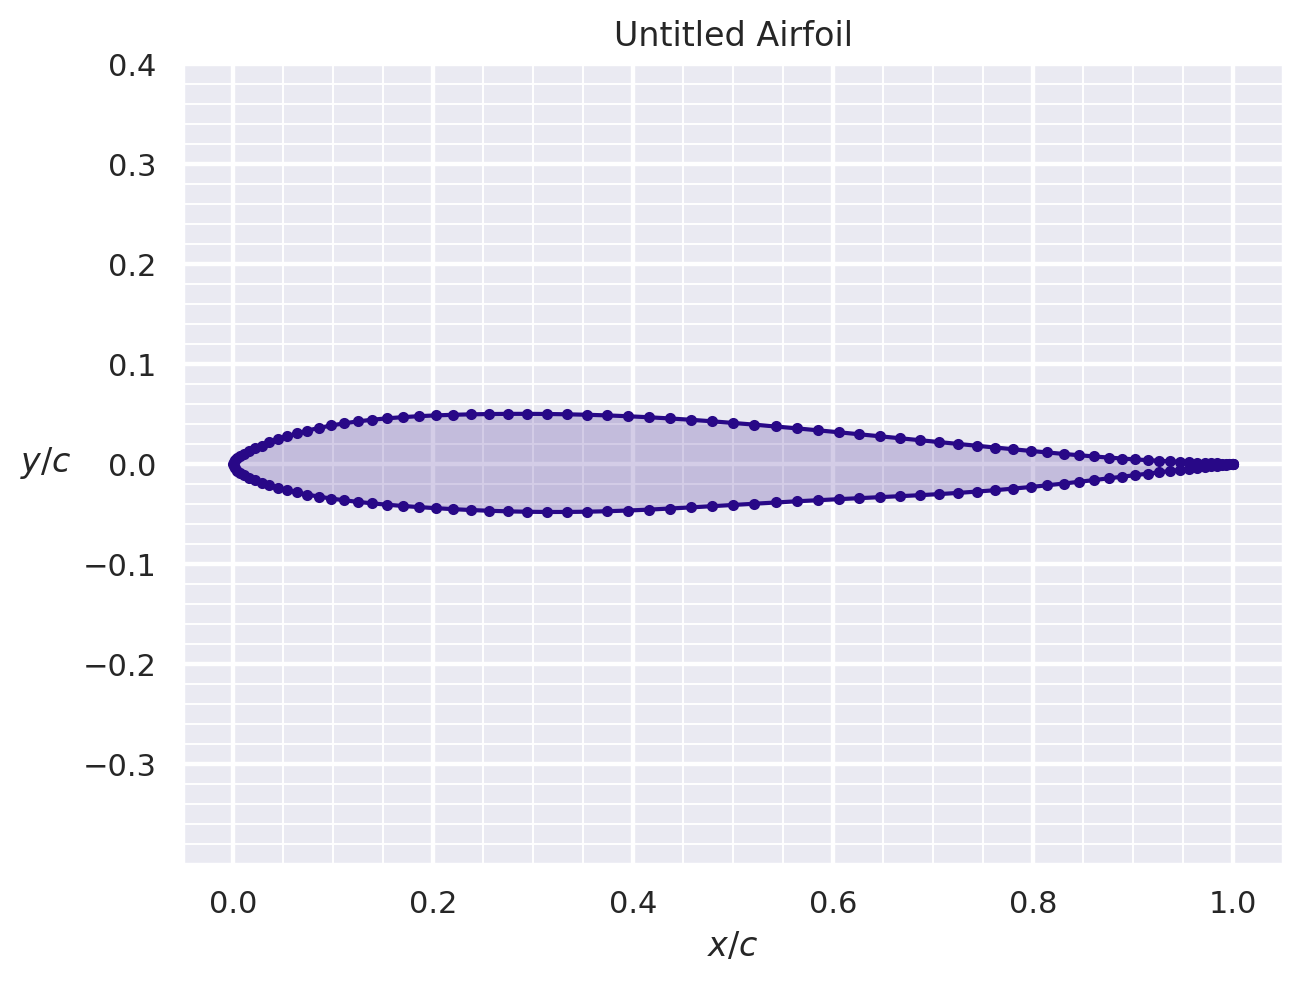

In [32]:
latent_vector = tf.random.normal([1, 128])
coords, weights, parameters = generator(latent_vector)
print("Output shape: ", weights.shape)
print("Coordinates shape: ", coords.shape)
print(parameters)

test = Airfoil(coordinates=coords[0])
test.draw()